## Imports and setting up platform authentication

Please follow the displayed instructions to authenticate.

In [1]:
from obi_auth import get_token
from entitysdk.client import Client
from entitysdk.models import ReconstructionMorphology
import pandas as pd

import neurom
import os

from ipywidgets import widgets
from neurom.check.runner import CheckRunner
from matplotlib import pyplot as plt

client = Client(environment="staging")
token = get_token(environment="staging", auth_mode="daf")

## Define functions for accessing the data
Here, we define helper functions for downloading selected assets from the platform.

In [2]:
def dataframe_from_entity_ids(entity_ids):
    client = Client(environment="staging")
    def pretty(m):
        def pretty_value(v):
            if isinstance(v, dict):
                if 'name' in v:
                    return v['name']
            return v
        ret = { p:pretty_value(v) for p,v in m.model_dump().items()}
        ret["entity_type"] = type(m)
        return ret

    entities = pd.DataFrame([
        pretty(client.get_entity(entity_id=entity_id,\
                                entity_type=ReconstructionMorphology,
                                token=token))
        for entity_id in entity_ids
    ])
    return entities

def get_matching_asset_types(df_in, match="all"):
    assert len(df_in) >= 1, "At least one entity required!"
    per_entity_all_types = df_in["assets"].apply(lambda _x: {__x["content_type"] for __x in _x})
    extensions = per_entity_all_types.iloc[0]
    for row in per_entity_all_types.iloc[1:]:
        if match == "all":
            extensions = extensions.intersection(row)
        elif match == "any":
            extensions.update(row)
        else:
            raise ValueError(f"Unknown value for {match}")
    if "application/h5" in extensions:
        extensions.remove("application/h5")
    return list(extensions)

def filter_to_asset_type(df_in, target_type):
    def per_row(row):
        matches = [
            _asset for _asset in row["assets"]
            if _asset["content_type"] == target_type
            ]
        if len(matches) == 0:
            return pd.Series({"has_asset": False,
                              "load_asset_id": -1,
                              "load_asset_extension": os.path.split(target_type)[1]})
        return pd.Series({"has_asset": True,
                              "load_asset_id": matches[0]["id"],
                              "load_asset_extension": os.path.split(target_type)[1]})
    df_in = pd.concat([df_in, df_in.apply(per_row, axis=1)], axis=1)
    return df_in.loc[df_in["has_asset"]]

def load_morphology_assets_from_df(df_in, client, token):
    def per_row(row):
        m = neurom.load_morphology(
            client.download_content(
                entity_id=row["id"],
                entity_type=row["entity_type"],
                asset_id=row["load_asset_id"],
                token=token
            ).decode("UTF-8"),
            reader=row["load_asset_extension"]
        )
        return m
    df_in["_morphology"] = df_in.apply(per_row, axis=1)
    return df_in


## Select entities to analyze

Here, we define which morphology entities to load and analyze.

Please fill in the unique IDs of the selected entities into the empty list below!

In [ ]:
entity_ids = [
    # FILL IN THE IDs OF THE SELECTED MORPHOLOGY ENTITIES HERE!
]

entities = dataframe_from_entity_ids(entity_ids)
extension_wdgt = widgets.Dropdown(options=get_matching_asset_types(entities),
                                  description="Load extension")

In [4]:
# morphology_checks: concern the valid structure of a morphology
# options: set the tolerance parameters for the checks

config = {
    "checks": {
        "morphology_checks": [
            "has_axon",
            "has_basal_dendrite",
            "has_apical_dendrite",
            "has_no_jumps",
            "has_no_fat_ends",
            "has_nonzero_soma_radius",
            "has_all_nonzero_neurite_radii",
            "has_all_nonzero_section_lengths",
            "has_all_nonzero_segment_lengths",
            "has_no_flat_neurites",
            "has_nonzero_soma_radius",
            "has_no_narrow_start",
            "has_no_dangling_branch",
        ]
    },
    "options": {
        "has_nonzero_soma_radius": 0.0,
        "has_all_nonzero_neurite_radii": 0.007,
        "has_all_nonzero_segment_lengths": 0.01,
        "has_all_nonzero_section_lengths": 0.01,
    },
}
# create a CheckRunner object by providing the configuration dict
check_runner = CheckRunner(config)

display(extension_wdgt)

Dropdown(description='Load extension', options=('application/swc', 'application/asc'), value='application/swc'…

In [5]:
contents = filter_to_asset_type(entities, target_type="application/swc")
contents = load_morphology_assets_from_df(contents, client, token)

def run_wrapper(_morph):
    try:
        res = check_runner._check_loop(_morph, "morphology_checks")
        res = pd.Series(res[1])
        res["Test ran to completion"] = True
    except:
        res = pd.Series({"Test ran to completion": False})
    return res

res = contents["_morphology"].apply(run_wrapper).fillna(False)

/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/neurom/morphmath.py:490: RuntimeWarning: divide by zero encountered in dot
  scalar_projections = points.dot(eigenvectors)
/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/neurom/morphmath.py:490: RuntimeWarning: overflow encountered in dot
  scalar_projections = points.dot(eigenvectors)
/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/neurom/morphmath.py:490: RuntimeWarning: invalid value encountered in dot
  scalar_projections = points.dot(eigenvectors)
/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/neurom/morphmath.py:490: RuntimeWarning: divide by zero encountered in dot
  scalar_projections = points.dot(eigenvectors)
/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/neurom/morphmath.py:490: RuntimeWarning: overflow encountered in dot
  scalar_projections = points.dot(eigenvectors)
/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/neurom/m

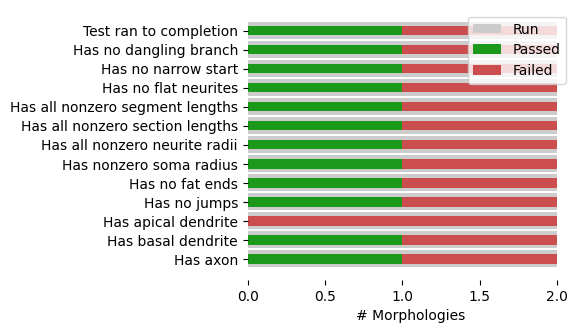

HTML(value='<b>Pick a test to list morphologies failing it</b>')

Dropdown(options=('Has axon', 'Has basal dendrite', 'Has apical dendrite', 'Has no jumps', 'Has no fat ends', …

HTML(value='')

In [6]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.3, 0.1, 0.65, 0.9])
ttl = len(res) - res.isna().sum(axis=0)
passed = res.astype(int).sum(axis=0)
ax.barh(range(len(ttl)), ttl, height=0.9, color=[0.8, 0.8, 0.8], label="Run")
ax.barh(range(len(passed)), passed, height=0.5, color=[0.1, 0.6, 0.1], label="Passed")
ax.barh(range(len(passed)), ttl - passed, height=0.5, left=passed, color=[0.8, 0.3, 0.3], label="Failed")
ax.set_yticks(range(len(passed)))
ax.set_yticklabels(passed.index)
ax.set_xlabel("# Morphologies")
ax.set_frame_on(False)
plt.legend()
plt.show()

pick_test_wdgt = widgets.Dropdown(options=res.columns)
output = widgets.HTML()
display(widgets.HTML(
    value="<b>Pick a test to list morphologies failing it</b>"
))
display(pick_test_wdgt)
display(output)

def display_func(sel_test_name):
    col = res[sel_test_name]
    morphs = contents.name[col == False].values
    output.value=", ".join(list(morphs))
_ = widgets.interactive(display_func, sel_test_name=pick_test_wdgt)

